In [1]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [8]:
limf = [49,58,75,110,112,132,151,276,281,362]
med = 200

stat, pvalue = stats.wilcoxon(limf - np.full((len(limf), ), med), mode = 'approx')

print(pvalue.round(4))

0.2845


In [11]:
forests_noncut = [22,22,15,13,19,19,18,20,21,13,13,15]
forests_cut = [17,18,18,15,12,4,14,15,10]

stat, pvalue = stats.mannwhitneyu(forests_noncut, forests_cut, alternative = 'greater')

print(pvalue.round(4))

0.029


In [12]:
challenger = pd.read_csv('challenger.txt', sep = '\t')

In [13]:
challenger.head()

,Unnamed: 0,Temperature,Incident
0,Apr12.81,18.9,0
1,Nov12.81,21.1,1
2,Mar22.82,20.6,0
3,Nov11.82,20.0,0
4,Apr04.83,19.4,0


In [14]:
challenger.describe()

,Temperature,Incident
count,23.000000,23.000000
mean,20.860870,0.304348
std,3.919501,0.470472
min,11.700000,0.000000
25%,19.400000,0.000000
50%,21.100000,0.000000
75%,23.900000,1.000000
max,27.200000,1.000000


In [21]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

In [44]:
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [25]:
temp_1 = challenger[challenger['Incident'] == 1].Temperature.values
temp_0 = challenger[challenger['Incident'] == 0].Temperature.values

In [27]:
np.random.seed(0)

samples_1 = get_bootstrap_samples(temp_1, 1000)
samples_0 = get_bootstrap_samples(temp_0, 1000)

In [34]:
means_1 = samples_1.mean(axis = 1)
means_0 = samples_0.mean(axis = 1)

In [43]:
temps = means_1 - means_0

In [45]:
boundaries = stat_intervals(temps, 0.05)

In [48]:
boundaries[1].round(4)

-1.4504

In [70]:
def permutation_t_stat_ind(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)

In [71]:
def get_random_combinations(n1, n2, max_combinations):
    index = list(range(n1 + n2))
    indices = set([tuple(index)])
    for i in range(max_combinations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]

In [72]:
def permutation_zero_dist_ind(sample1, sample2, max_combinations = None):
    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)
    
    if max_combinations:
        indices = get_random_combinations(n1, len(sample2), max_combinations)
    else:
        indices = [(list(index), filter(lambda i: i not in index, range(n))) \
                    for index in itertools.combinations(range(n), n1)]
    
    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() \
             for i in indices]
    return distr

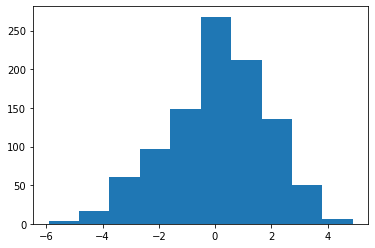

In [76]:
pylab.hist(permutation_zero_dist_ind(temp_1, temp_0, max_combinations = 1000))
pylab.show()

In [77]:
def permutation_test(sample, mean, max_permutations = None, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_ind(sample, mean)
    
    zero_distr = permutation_zero_dist_ind(sample, mean, max_permutations)
    
    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)
    
    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr)

In [78]:
np.random.seed(0)

permutation_test(temp_1, temp_0, max_permutations = 10000)

0.0057